In [3]:
%matplotlib inline
# imported necessary libraries
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import cross_val_score
#from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
#from sklearn import cross_validation
from sklearn.model_selection import cross_validate


# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 limit 1000
""", con) 

def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'




In [ ]:
https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-naive-bayes

In [4]:


#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative


In [5]:
filtered_data.shape #looking at the number of attributes and size of the data
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [7]:


#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')



In [8]:
final = sorted_data.drop_duplicates(subset = {"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(998, 10)

In [9]:
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.8

In [11]:


final = final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]



In [12]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(998, 10)


positive    841
negative    157
Name: Score, dtype: int64

In [13]:
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

0
I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!


In [14]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'where', 'being', 'been', 'shan', 'himself', 'while', 'to', 'again', 'aren', 'own', "hasn't", 'few', 'their', "she's", 'nor', 'all', 'yourselves', 'more', 'wouldn', 'now', 'weren', "mightn't", 'other', 'itself', 'because', "isn't", 'only', 'didn', 'mustn', 've', 'very', 'here', 'against', "you're", "it's", 'once', 'o', 'doesn', 'hadn', "doesn't", 'down', 'it', 'hasn', 'for', 'am', 'ain', "needn't", 'that', 'd', 'my', 'no', 'should', 'in', 'have', 'were', 'won', 're', 'has', 'isn', 'about', 'hers', 'him', 'before', 'off', 'doing', 'myself', 'but', "hadn't", 'his', "that'll", 'same', 'whom', 'does', 'an', 'after', 'your', 'at', 'some', 'theirs', 'ma', 'this', "shan't", 'during', 'from', 'which', 'what', 'they', 'we', 'those', 'is', 'you', "you'll", "haven't", 'ourselves', 'so', 'y', 'when', 'and', 'themselves', 'be', 'do', 'the', 'having', 'haven', 'don', 'through', 'over', 'how', 'below', 'up', 'shouldn', 'yourself', 'not', 'most', "aren't", 'further', "shouldn't", 'with', 'will', 'the

In [15]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [16]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [17]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [18]:
con = sqlite3.connect("final.sqlite")
cleaned_data = pd.read_sql_query("select * from Reviews", con)

In [19]:
cleaned_data.shape

(998, 12)

In [20]:
cleaned_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,10,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,positive,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...,b'dont know cactus tequila uniqu combin ingred...
1,232,253,B0002567IW,A1SSKFPX72MSMR,"Janna M. Sicard ""missjanna""",0,0,negative,1344556800,Sad outcome,"Five minutes in, one tentacle was bitten off, ...",b'five minut one tentacl bitten ball insid cra...
2,171,188,B00029XIZI,A2S72TUJDQUBMH,Nadia,0,0,positive,1236124800,Miracle,My Scotties were full of hot spots and when I ...,b'scotti full hot spot use within week hot spo...
3,932,1011,B0002MKFEM,A3QLX72AO0DD5Z,Carlito Picache,1,2,positive,1226361600,Way too salty,I tried this and I found it too salty.<br />Pl...,b'tri found salti plus ate fish sauc fish real...
4,893,969,B0002XIB2Y,A3NV17B17PFB7G,Susan,3,3,positive,1228176000,WONDERFUL gravy!,"This gravy mix is excellent ... except, don't ...",b'gravi mix excel except dont use water call u...


In [21]:
cleaned_data["Score"].value_counts()

positive    841
negative    157
Name: Score, dtype: int64

In [22]:
# To randomly sample 100k points from both class

data_pos = cleaned_data[cleaned_data["Score"] == "positive"].sample(n = 50)
data_neg = cleaned_data[cleaned_data["Score"] == "negative"].sample(n = 50)
final_100k = pd.concat([data_pos, data_neg])
final_100k.shape

(100, 12)

In [23]:
final_100k["Time"] = pd.to_datetime(final_100k["Time"], unit = "s")
final_100k = final_100k.sort_values(by = "Time")
final_100k.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
77,897,973,B000F0G75W,A3QOSBTILZ84HY,"Junie ""finaj""",0,0,positive,2007-03-08,Eco sugar,Its great to be able to get sugar this way.Its...,b'great abl get sugar way good eat go use suga...
240,460,498,B000G6RYNE,AJQD2WWJYOYFQ,bubbles,0,0,positive,2007-08-09,"Tangy, spicy, and sweet- oh my!",Kettle Chips Spicy Thai potato chips have the ...,b'kettl chip spici thai potato chip perfect am...
515,366,399,B001ELL6O8,ALSAOZ1V546VT,"A Research It Maven ""Just the facts please""",1,1,positive,2008-01-13,Arrowhead Mills whole grain buttermilk Pancake...,HEY! These are GREAT Waffles and Pancakes! We ...,b'hey great waffl pancak add mix tho recipi ba...
535,47,51,B001EO5QW8,A108P30XVUFKXY,Roberto A,0,7,negative,2008-02-19,Don't like it,"This oatmeal is not good. Its mushy, soft, I d...",b'oatmeal good mushi soft dont like quaker oat...
213,456,494,B000G6RYNE,A3N9DN0V2YXAXA,musicalcharge,0,0,positive,2008-02-22,You have to love sea salt and vinegar already,"But if you happen to, like me, there is no bet...",b'happen like better sea salt vinegar chip ive...


In [24]:
# Fuction to compute alpha value
def naive_bayes(X_train, y_train):
    
    alpha_values = np.arange(1, 500, 0.5)
        

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for alpha in alpha_values:
        mnb = MultinomialNB(alpha = alpha)
        scores = cross_val_score(mnb, X_train, y_train, cv = 10, scoring = 'accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best alpha
    optimal_alpha = alpha_values[MSE.index(min(MSE))]
    print('\nThe optimal number of alpha is %d.' % optimal_alpha)

    # plot misclassification error vs alpha
    plt.plot(alpha_values, MSE, marker = '*') 

    #for xy in zip(alpha_values, np.round(MSE,3)):
        #plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title("Misclassification Error vs alpha")
    plt.xlabel('value of alpha')
    plt.ylabel('Misclassification Error')
    plt.show()

    #print("the misclassification error for each value of alpha is : ", np.round(MSE,3))
    return optimal_alpha

In [25]:
# 100k data which will use to train model after vectorization
X = final_100k["CleanedText"]
print("shape of X:", X.shape)

shape of X: (100,)


In [27]:
# class label
y = final_100k["Score"]
print("shape of y:", y.shape)

shape of y: (100,)


In [28]:
# split data into train and test where 70% data used to train model and 30% for test
# final_4000[:int(len(final_4000) * 0.75)], final_4000[int(len(final_4000) * 0.75):]
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, x_test.shape)

(70,) (70,) (30,)


In [2]:
# Train Vectorizor
from sklearn.feature_extraction.text import CountVectorizer 

bow = CountVectorizer()
X_train = bow.fit_transform(X_train)



NameError: name 'X_train' is not defined

In [30]:
# Test Vectorizor
x_test = bow.transform(x_test)

In [31]:
x_test.shape


(30, 1069)

In [32]:
X_train.shape

(70, 1069)

In [33]:
y_train.shape

(70,)

In [112]:
from sklearn.model_selection import GridSearchCV
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [113]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(x_test)
#    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision



/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/an

Best parameters set found on development set:

{'C': 1, 'kernel': 'linear'}

Grid scores on development set:

0.279 (+/-0.018) for {'C': 1, 'kernel': 'rbf', 'gamma': 0.001}
0.279 (+/-0.018) for {'C': 1, 'kernel': 'rbf', 'gamma': 0.0001}
0.279 (+/-0.018) for {'C': 10, 'kernel': 'rbf', 'gamma': 0.001}
0.279 (+/-0.018) for {'C': 10, 'kernel': 'rbf', 'gamma': 0.0001}
0.279 (+/-0.018) for {'C': 100, 'kernel': 'rbf', 'gamma': 0.001}
0.279 (+/-0.018) for {'C': 100, 'kernel': 'rbf', 'gamma': 0.0001}
0.750 (+/-0.353) for {'C': 1000, 'kernel': 'rbf', 'gamma': 0.001}
0.279 (+/-0.018) for {'C': 1000, 'kernel': 'rbf', 'gamma': 0.0001}
0.759 (+/-0.255) for {'C': 1, 'kernel': 'linear'}
0.750 (+/-0.353) for {'C': 10, 'kernel': 'linear'}
0.750 (+/-0.353) for {'C': 100, 'kernel': 'linear'}
0.750 (+/-0.353) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.


# Tuning hyper-parameters 

/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [98]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']
clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
clf.fit(X_train, y_train)


auc = make_scorer(roc_auc_score)
mdl = svc(probability = True, random_state = 1)
rand_list ={'C': [1, 10, 100, 1000],'gamma': [1e-3, 1e-4]}
#rand_search =RandomizedSearchCV(mdl, param_distributions = rand_list, n_iter = 20, n_jobs = 4, cv = 3, random_state = 2017, scoring = auc) 
rand_search =RandomizedSearchCV(mdl, param_distributions = rand_list, n_iter = 20,  n_jobs = 4, cv = 3, random_state = 2017,  scoring='%s_macro' % score) 
rand_search.fit(X_train, y_train)



/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/an

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=1,
  shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=4,
          param_distributions={'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]},
          pre_dispatch='2*n_jobs', random_state=2017, refit=True,
          return_train_score='warn', scoring='precision_macro', verbose=0)

In [100]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.svm import SVC as svc 
import scipy as sp
from sklearn.pipeline import Pipeline
from scipy.stats import uniform as sp_rand
from sklearn.metrics import make_scorer, roc_auc_score
from scipy import stats
mdl = svc(probability = True, random_state = 1)
rand_list ={'C': [1, 10, 100, 1000],'gamma': [1e-3, 1e-4]}
#rand_search =RandomizedSearchCV(mdl, param_distributions = rand_list, n_iter = 20, n_jobs = 4, cv = 3, random_state = 2017, scoring = auc) 
#rand_search =RandomizedSearchCV(mdl, param_distributions = rand_list, n_iter = 20,  n_jobs = 4, cv = 3, random_state = 2017,  scoring='%s_macro' % score) 
#rand_search.fit(X_train, y_train) 

In [102]:

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    rand_search =RandomizedSearchCV(mdl, param_distributions = rand_list, n_iter = 20,  n_jobs = 4, cv = 3, random_state = 2017,  scoring='%s_macro' % score) 
    rand_search.fit(X_train, y_train) 
    

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Random scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(x_test)
#    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 100, 'kernel': 'rbf', 'gamma': 0.001}

Random scores on development set:

0.279 (+/-0.018) for {'C': 1, 'kernel': 'rbf', 'gamma': 0.001}
0.279 (+/-0.018) for {'C': 1, 'kernel': 'rbf', 'gamma': 0.0001}
0.679 (+/-0.473) for {'C': 10, 'kernel': 'rbf', 'gamma': 0.001}
0.279 (+/-0.018) for {'C': 10, 'kernel': 'rbf', 'gamma': 0.0001}
0.818 (+/-0.145) for {'C': 100, 'kernel': 'rbf', 'gamma': 0.001}
0.724 (+/-0.322) for {'C': 100, 'kernel': 'rbf', 'gamma': 0.0001}
0.818 (+/-0.145) for {'C': 1000, 'kernel': 'rbf', 'gamma': 0.001}
0.773 (+/-0.124) for {'C': 1000, 'kernel': 'rbf', 'gamma': 0.0001}
0.773 (+/-0.124) for {'C': 1, 'kernel': 'linear'}
0.773 (+/-0.124) for {'C': 10, 'kernel': 'linear'}
0.773 (+/-0.124) for {'C': 100, 'kernel': 'linear'}
0.773 (+/-0.124) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are compute

/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best parameters set found on development set:

{'C': 100, 'kernel': 'rbf', 'gamma': 0.001}

Random scores on development set:

0.279 (+/-0.018) for {'C': 1, 'kernel': 'rbf', 'gamma': 0.001}
0.279 (+/-0.018) for {'C': 1, 'kernel': 'rbf', 'gamma': 0.0001}
0.679 (+/-0.473) for {'C': 10, 'kernel': 'rbf', 'gamma': 0.001}
0.279 (+/-0.018) for {'C': 10, 'kernel': 'rbf', 'gamma': 0.0001}
0.818 (+/-0.145) for {'C': 100, 'kernel': 'rbf', 'gamma': 0.001}
0.724 (+/-0.322) for {'C': 100, 'kernel': 'rbf', 'gamma': 0.0001}
0.818 (+/-0.145) for {'C': 1000, 'kernel': 'rbf', 'gamma': 0.001}
0.773 (+/-0.124) for {'C': 1000, 'kernel': 'rbf', 'gamma': 0.0001}
0.773 (+/-0.124) for {'C': 1, 'kernel': 'linear'}
0.773 (+/-0.124) for {'C': 10, 'kernel': 'linear'}
0.773 (+/-0.124) for {'C': 100, 'kernel': 'linear'}
0.773 (+/-0.124) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.




/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [107]:
# data
X = final_100k["CleanedText"]

# Target/class-label
y = final_100k["Score"]
# Split data
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(70,) (30,) (70,) (30,)


In [108]:
#from sklearn.feature_extraction.text import TfidfVectorizer

#tfidf = TfidfVectorizer()
#tfidf_data = tfidf.fit_transform(final_4000["CleanedText"])
#tfidf_data


#tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
#tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
#tf_idf_vect= TfidfVectorizer(ngram_range=(1,2))

#tf_idf_vect=dfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
#features = tfidf.fit_transform(df.Consumer_complaint_narrative).toarray()

#X_train = tf_idf_vect.fit_transform(X_train)
#X_Train=CountVectorizer(ngram_range=(1,2) )
#y_train.shape


from sklearn.feature_extraction.text import TfidfVectorizer

#tfidf = TfidfVectorizer()
#tfidf_data = tfidf.fit_transform(final_4000["CleanedText"])
#tfidf_data
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
X_train = tf_idf_vect.fit_transform(X_train)
X_train

<70x3627 sparse matrix of type '<class 'numpy.float64'>'
	with 4852 stored elements in Compressed Sparse Row format>

In [109]:
# Convert test text data to its vectorizor
x_test = tf_idf_vect.transform(x_test)
x_test.shape

(30, 3627)

In [110]:
tfidf_features = tf_idf_vect.get_feature_names()

In [114]:
from __future__ import print_function

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)

# Loading the Digits dataset


# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']


Automatically created module for IPython interactive environment


In [119]:
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(x_test)
#    print(classification_report(y_true, y_pred))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

# Tuning hyper-parameters for precision



/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/an

Best parameters set found on development set:

{'C': 1, 'kernel': 'linear'}

Grid scores on development set:

0.279 (+/-0.018) for {'C': 1, 'kernel': 'rbf', 'gamma': 0.001}
0.279 (+/-0.018) for {'C': 1, 'kernel': 'rbf', 'gamma': 0.0001}
0.279 (+/-0.018) for {'C': 10, 'kernel': 'rbf', 'gamma': 0.001}
0.279 (+/-0.018) for {'C': 10, 'kernel': 'rbf', 'gamma': 0.0001}
0.279 (+/-0.018) for {'C': 100, 'kernel': 'rbf', 'gamma': 0.001}
0.279 (+/-0.018) for {'C': 100, 'kernel': 'rbf', 'gamma': 0.0001}
0.750 (+/-0.353) for {'C': 1000, 'kernel': 'rbf', 'gamma': 0.001}
0.279 (+/-0.018) for {'C': 1000, 'kernel': 'rbf', 'gamma': 0.0001}
0.759 (+/-0.255) for {'C': 1, 'kernel': 'linear'}
0.750 (+/-0.353) for {'C': 10, 'kernel': 'linear'}
0.750 (+/-0.353) for {'C': 100, 'kernel': 'linear'}
0.750 (+/-0.353) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.


# Tuning hyper-parameters 

/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [ ]:
mdl = svc(probability = True, random_state = 1)
rand_list ={'C': [1, 10, 100, 1000],'gamma': [1e-3, 1e-4]}

In [120]:
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    rand_search =RandomizedSearchCV(mdl, param_distributions = rand_list, n_iter = 20,  n_jobs = 4, cv = 3, random_state = 2017,  scoring='%s_macro' % score) 
    rand_search.fit(X_train, y_train) 
    

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Random scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(x_test)
#    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision



/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The

Best parameters set found on development set:

{'C': 1000, 'kernel': 'rbf', 'gamma': 0.001}

Random scores on development set:

0.500 (+/-0.000) for {'C': 1, 'kernel': 'rbf', 'gamma': 0.001}
0.500 (+/-0.000) for {'C': 1, 'kernel': 'rbf', 'gamma': 0.0001}
0.500 (+/-0.000) for {'C': 10, 'kernel': 'rbf', 'gamma': 0.001}
0.500 (+/-0.000) for {'C': 10, 'kernel': 'rbf', 'gamma': 0.0001}
0.500 (+/-0.000) for {'C': 100, 'kernel': 'rbf', 'gamma': 0.001}
0.500 (+/-0.000) for {'C': 100, 'kernel': 'rbf', 'gamma': 0.0001}
0.689 (+/-0.254) for {'C': 1000, 'kernel': 'rbf', 'gamma': 0.001}
0.500 (+/-0.000) for {'C': 1000, 'kernel': 'rbf', 'gamma': 0.0001}
0.617 (+/-0.167) for {'C': 1, 'kernel': 'linear'}
0.689 (+/-0.254) for {'C': 10, 'kernel': 'linear'}
0.689 (+/-0.254) for {'C': 100, 'kernel': 'linear'}
0.689 (+/-0.254) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.


# Tuning

In [208]:
# Number of samples encountered for each class during fitting

nb_optimal.class_count_

array([36., 34.])

In [209]:
# Empirical log probability of features given a class(i.e. P(x_i|y))

log_prob = nb_optimal.feature_log_prob_
log_prob

array([[-8.18362686, -8.18362686, -8.18362686, ..., -8.02338122,
        -8.00906668, -8.18362686],
       [-8.11263724, -8.11263724, -7.86653797, ..., -8.05931192,
        -8.17370529, -8.04884166]])

In [210]:
feature_prob = pd.DataFrame(log_prob, columns = tfidf_features)
feature_prob_tr = feature_prob.T
feature_prob_tr.shape


(3315, 2)

In [211]:
# To show top 10 feature from both class
print("Top 10 negative features:-\n",feature_prob_tr[0].sort_values(ascending = False)[0:10])
print("\n\n Top 10 positive features:-\n",feature_prob_tr[1].sort_values(ascending = False)[0:10])


Top 10 negative features:-
 chip     -7.285259
realli   -7.499129
tast     -7.512765
kettl    -7.519233
bag      -7.525978
like     -7.601233
look     -7.605094
brand    -7.613934
good     -7.621985
bad      -7.643243
Name: 0, dtype: float64


 Top 10 positive features:-
 chip      -7.365098
tea       -7.435040
great     -7.476286
use       -7.503024
good      -7.504433
time      -7.506053
product   -7.547414
love      -7.558205
healthi   -7.585562
tast      -7.586041
Name: 1, dtype: float64


In [212]:
# Accuracy on train data
train_acc_tfidf = nb_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_tfidf)

Train accuracy 1.0


In [213]:
# Error on train data
train_err_tfidf = 1-train_acc_tfidf
print("Train Error %f%%" % (train_err_tfidf))

Train Error 0.000000%


In [214]:
# evaluate accuracy
acc_tfidf = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the naive bayes classifier for alpha = %d is %f%%' % (optimal_alpha_tfidf, acc_tfidf))


The accuracy of the naive bayes classifier for alpha = 1 is 63.333333%


In [215]:
#from sklearn.matrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[12,  2],
       [ 9,  7]])

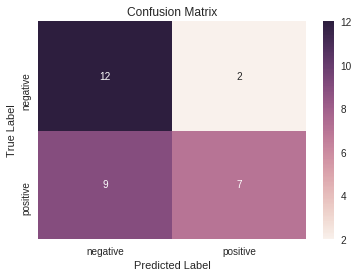

In [216]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [217]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

   negative       0.57      0.86      0.69        14
   positive       0.78      0.44      0.56        16

avg / total       0.68      0.63      0.62        30

